In [8]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import helper_utils

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
data_path = "./data"

In [11]:
train_dataset_without_transform = torchvision.datasets.MNIST(
    root=data_path,
    train=True,
    download=True,
)

In [12]:
# Get the first sample (index 0), as a (image, label) tuple
image_pil, label = train_dataset_without_transform[0]

print(f"Image Type: {type(image_pil)}")
print(f"Image Dimensions: {image_pil.size}")
print(f"Label Type: {type(label)}")
print(f"Label Value: {label}")

Image Type: <class 'PIL.Image.Image'>
Image Dimensions: (28, 28)
Label Type: <class 'int'>
Label Value: 5


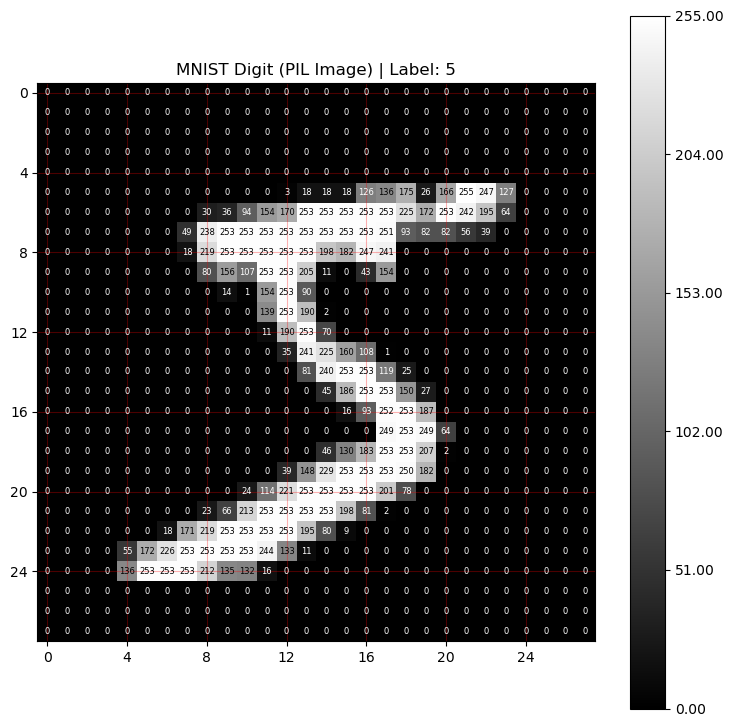

In [13]:
# Visualize the sample image and its corresponding label
helper_utils.display_image(image_pil, label, "MNIST Digit (PIL Image)", show_values=True)

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [15]:
train_dataset = torchvision.datasets.MNIST(
    root=data_path,
    train=True,
    download=True,
    transform=transform
)

In [16]:
image_tensor, label = train_dataset[0]

print(f"Image Type: {type(image_tensor)}")
print(f"Image Shape After Transform: {image_tensor.shape}")
print(f"Label Type: {type(label)}")
print(f"Label Value: {label}")

Image Type: <class 'torch.Tensor'>
Image Shape After Transform: torch.Size([1, 28, 28])
Label Type: <class 'int'>
Label Value: 5


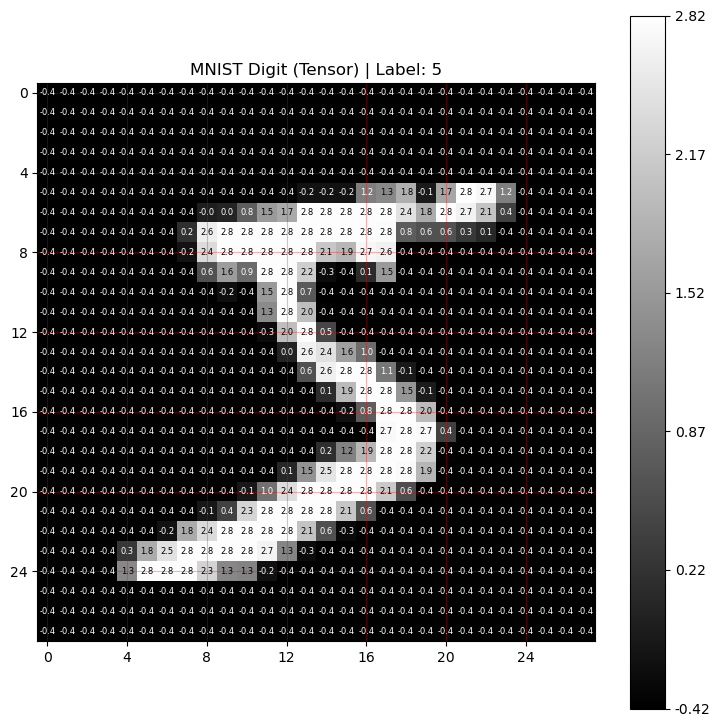

In [17]:
helper_utils.display_image(image_tensor, label, "MNIST Digit (Tensor)", show_values=True)

In [18]:
test_dataset = torchvision.datasets.MNIST(
    root=data_path,
    train=False,
    download=True,
    transform=transform
)

In [19]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [20]:
class SimpleMNISTDNN(nn.Module):
    """
    A simple deep neural network model for the MNIST dataset.

    This model consists of a flatten layer followed by two linear layers
    with a ReLU activation function. It is designed for classification tasks
    on 28x28 grayscale images.
    """
    def __init__(self):
        """
        Initialize the layers of the neural network.
        """
        super().__init__()

        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Args:
            x: The input tensor.

        Returns:
            The output tensor after passing through the network layers.
        """
        x = self.flatten(x)
        x = self.layers(x)
        return x

In [21]:
# initialize the neural network model.
model = SimpleMNISTDNN().to(device)

loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
def train_epoch(model, loss_function, optimizer, train_loader, device):
    model = model.to(device)
    model.train()

    epoch_loss = 0.0

    running_loss = 0.0
    num_correct_predictions = 0
    total_predictions = 0
    total_batches = len(train_loader)

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        # Accumulate the loss for tracking and reporting
        loss_value = loss.item()
        epoch_loss += loss_value
        running_loss += loss_value

        # Calculate accuracy metrics for the current batch
        _, predicted_indices = outputs.max(1)
        batch_size = targets.size(0)
        total_predictions += batch_size
        num_correct_in_batch = predicted_indices.eq(targets).sum().item()
        num_correct_predictions += num_correct_in_batch

        # Check if it's time to print a progress update
        if (batch_idx + 1) % 134 == 0 or (batch_idx + 1) == total_batches:
            # Calculate average loss and accuracy for the current interval
            avg_running_loss = running_loss / 134
            accuracy = 100. * num_correct_predictions / total_predictions

            # Print the progress update
            print(f'\tStep {batch_idx + 1}/{total_batches} - Loss: {avg_running_loss:.3f} | Acc: {accuracy:.2f}%')

            # Reset the trackers for the next reporting interval
            running_loss = 0.0
            num_correct_predictions = 0
            total_predictions = 0

    # Calculate the average loss for the entire epoch
    avg_epoch_loss = epoch_loss / total_batches
    # Return the trained model and average epoch loss
    return model, avg_epoch_loss

In [23]:
def evaluate(model, test_loader, device):
    """
    Evaluates the model's accuracy on a test dataset.

    This function sets the model to evaluation mode, iterates through the test data,
    and calculates the percentage of correct predictions.

    Args:
        model: The neural network model to be evaluated.
        test_loader: A data loader containing the test dataset.
        device: The device (e.g., 'cpu' or 'cuda') to run the evaluation on.

    Returns:
        The accuracy of the model on the test dataset as a percentage.
    """

    model.eval()
    num_correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Performs a forward pass to get the model's output
            outputs = model(inputs)

            # Retrieves the index of the highest value in the output tensor, which represents the predicted class.
            _, predicted_indices = outputs.max(1)

            batch_size = targets.size(0)
            # Adds the batch size to the total number of predictions.
            total_predictions += batch_size

            # Compares the predicted indices with the actual target values.
            correct_predictions = predicted_indices.eq(targets)
            # Sum the correct predictions in the current batch.
            num_correct_in_batch = correct_predictions.sum().item()
            # Adds the correct predictions from the current batch to the total count.
            num_correct_predictions += num_correct_in_batch

    # Calculates the overall accuracy as a percentage.
    accuracy_percentage = (num_correct_predictions / total_predictions) * 100
    print((f'\tAccuracy - {accuracy_percentage:.2f}%'))

    return accuracy_percentage

In [24]:
num_epochs = 5

train_loss = []
test_acc = []

for epoch in range(num_epochs):
    print(f"\n[Training] Epoch {epoch + 1}:")
    trained_model, loss = train_epoch(model, loss_function, optimizer, train_loader, device)
    train_loss.append(loss)

    print(f"[Testing] Epoch {epoch + 1}:")
    accuracy = evaluate(trained_model, test_loader, device)
    test_acc.append(accuracy)


[Training] Epoch 1:
	Step 134/938 - Loss: 0.547 | Acc: 84.98%
	Step 268/938 - Loss: 0.289 | Acc: 91.53%
	Step 402/938 - Loss: 0.235 | Acc: 92.92%
	Step 536/938 - Loss: 0.210 | Acc: 93.69%
	Step 670/938 - Loss: 0.173 | Acc: 94.71%
	Step 804/938 - Loss: 0.158 | Acc: 95.18%
	Step 938/938 - Loss: 0.144 | Acc: 95.88%
[Testing] Epoch 1:
	Accuracy - 96.15%

[Training] Epoch 2:
	Step 134/938 - Loss: 0.116 | Acc: 96.44%
	Step 268/938 - Loss: 0.121 | Acc: 96.34%
	Step 402/938 - Loss: 0.112 | Acc: 96.72%
	Step 536/938 - Loss: 0.105 | Acc: 97.08%
	Step 670/938 - Loss: 0.107 | Acc: 96.86%
	Step 804/938 - Loss: 0.103 | Acc: 96.89%
	Step 938/938 - Loss: 0.101 | Acc: 96.64%
[Testing] Epoch 2:
	Accuracy - 96.87%

[Training] Epoch 3:
	Step 134/938 - Loss: 0.078 | Acc: 97.66%
	Step 268/938 - Loss: 0.065 | Acc: 97.87%
	Step 402/938 - Loss: 0.076 | Acc: 97.84%
	Step 536/938 - Loss: 0.073 | Acc: 97.75%
	Step 670/938 - Loss: 0.077 | Acc: 97.73%
	Step 804/938 - Loss: 0.079 | Acc: 97.62%
	Step 938/938 - Loss:

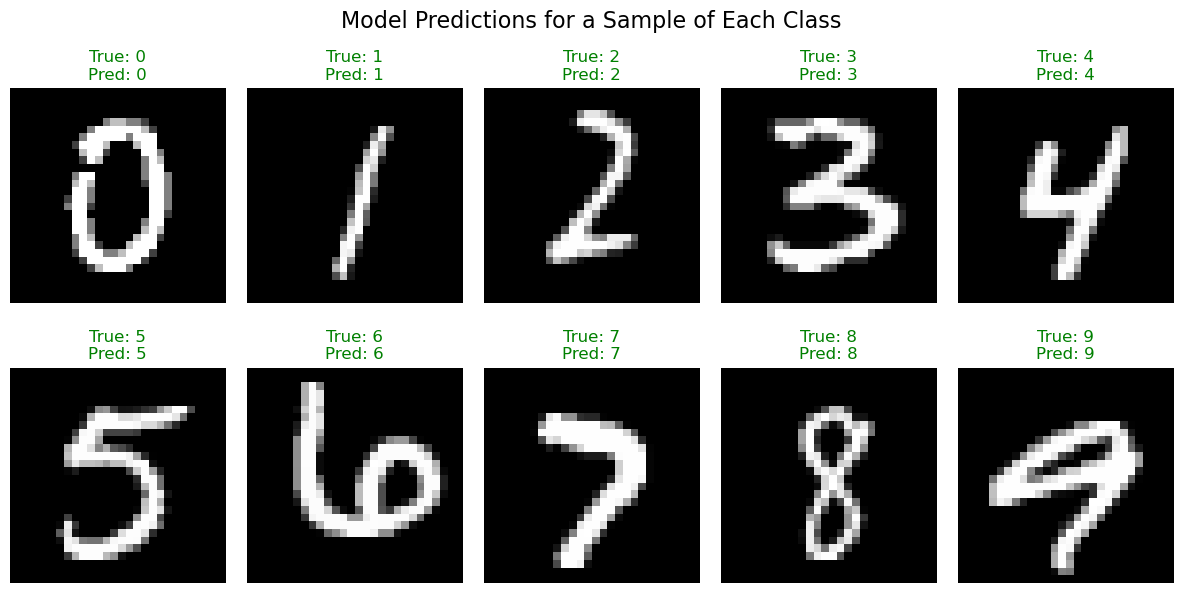

In [25]:
# Visualize model predictions on a random sample of test images
helper_utils.display_predictions(trained_model, test_loader, device)

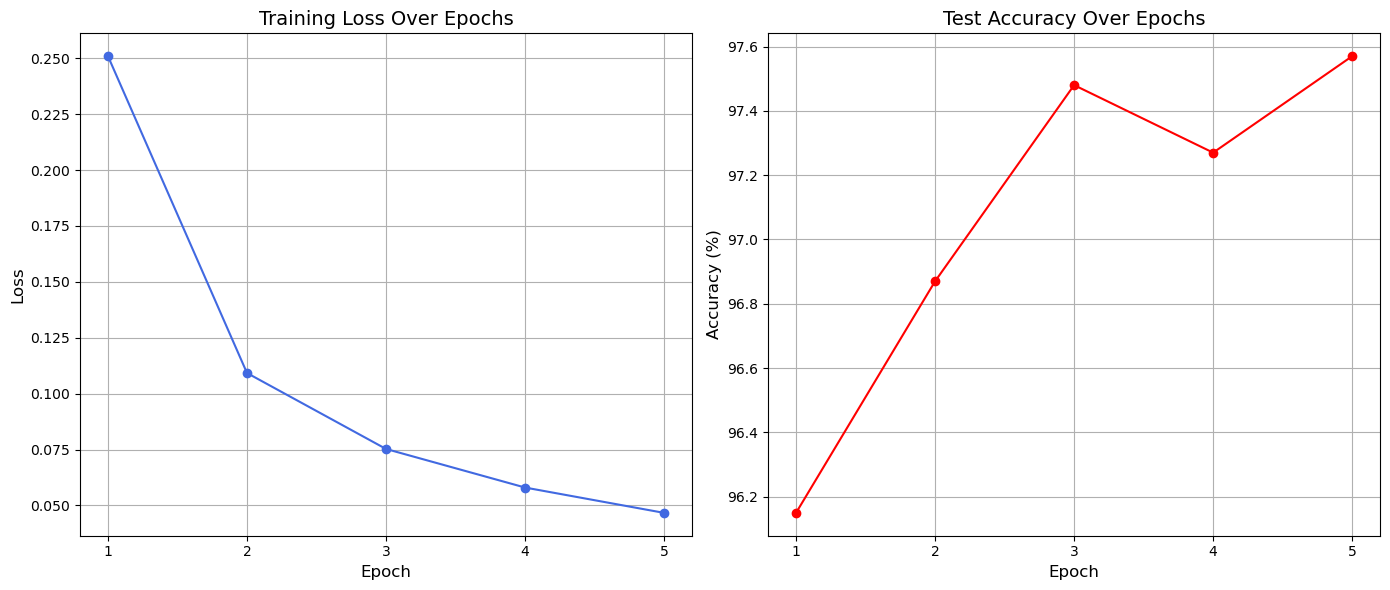

In [26]:
# Plot the training loss and test accuracy curves over all epochs
helper_utils.plot_metrics(train_loss, test_acc)